## MiDaS

In [1]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

/home/sadat/miniconda3/envs/dataloader/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('dog.jpg', <http.client.HTTPMessage at 0x7f725375c7f0>)

In [67]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/sadat/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/sadat/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [69]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (pad): ZeroPad2d((0, 1, 0, 1))
      )
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), strid

In [4]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/sadat/.cache/torch/hub/intel-isl_MiDaS_master


In [5]:
img = cv2.imread(filename)
img.shape

(1213, 1546, 3)

In [6]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
input_batch = transform(img).to(device)

(1213, 1546, 3)


In [7]:
input_batch.shape

torch.Size([1, 3, 384, 480])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


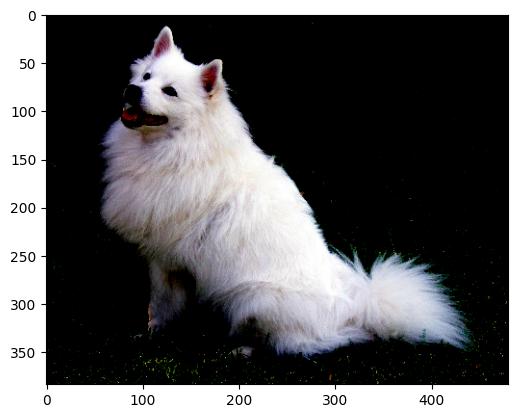

In [8]:
plt.imshow(input_batch[0].permute(1,2,0).cpu())

In [9]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

prediction.shape

torch.Size([1213, 1546])

In [10]:
output = prediction.cpu().numpy()

In [11]:
output.shape

(1213, 1546)

In [12]:
output.shape

(1213, 1546)

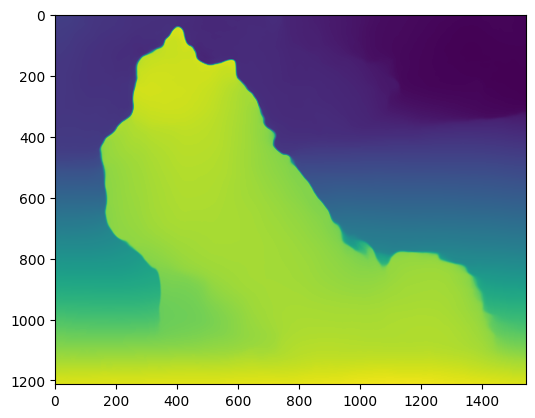

In [13]:
plt.imshow(output)

## WLASL10

In [5]:
import os
import torch
import torch.nn as nn
import wandb
import numpy as np

from torchvision import transforms
from mmaction.datasets import build_dataset

os.chdir('../')

In [6]:
train_cfg=dict(
    type='RawframeDataset',
    ann_file='data/wlasl/train_annotations.txt',
    data_prefix='data/wlasl/rawframes',
    pipeline=[
        dict(
            type='SampleFrames',
            clip_len=32,
            frame_interval=2,
            num_clips=1),
        dict(type='RawFrameDecode'),
        dict(type='Resize', scale=(-1, 256)),
        dict(type='RandomResizedCrop'),
        dict(type='Resize', scale=(224, 224), keep_ratio=False),
        dict(type='Flip', flip_ratio=0.5),
        dict(
            type='Normalize',
            mean=[123.675, 116.28, 103.53],
            std=[58.395, 57.12, 57.375],
            to_bgr=False),
        dict(type='FormatShape', input_format='NCTHW'),
        dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
        dict(type='ToTensor', keys=['imgs', 'label'])
    ])


test_cfg=dict(
        type='RawframeDataset',
        ann_file='data/wlasl/test_annotations.txt',
        data_prefix='data/wlasl/rawframes',
        pipeline=[
            dict(
                type='SampleFrames',
                clip_len=32,
                frame_interval=2,
                num_clips=1,
                test_mode=True),
            dict(type='RawFrameDecode'),
            dict(type='Resize', scale=(-1, 256)),
            dict(type='CenterCrop', crop_size=224),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_bgr=False),
            dict(type='FormatShape', input_format='NCTHW'),
            dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
            dict(type='ToTensor', keys=['imgs'])
    ])

In [7]:
# Building the datasets
batch_size = 2
train_dataset = build_dataset(train_cfg)
test_dataset = build_dataset(test_cfg)

# Setting up dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=4,
                                    pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                    batch_size=1,
                                    shuffle=True,
                                    num_workers=4,
                                    pin_memory=True)

In [8]:
for x in train_loader:
    break
x

{'imgs': tensor([[[[[[ 0.5536,  0.5536,  0.5364,  ..., -1.5014, -2.1179, -2.1179],
             [ 0.5536,  0.5536,  0.5536,  ..., -1.4843, -2.1179, -2.1179],
             [ 0.5707,  0.5707,  0.5536,  ..., -1.4843, -2.1179, -2.1179],
             ...,
             [-2.1008, -2.1008, -2.1008,  ..., -1.6042, -2.1179, -2.1179],
             [-2.1008, -2.1008, -2.1008,  ..., -1.6042, -2.1179, -2.1179],
             [-2.0837, -2.0837, -2.0837,  ..., -1.6213, -2.1179, -2.1179]],
 
            [[ 0.5536,  0.5536,  0.5364,  ..., -1.5014, -2.1179, -2.1179],
             [ 0.5536,  0.5536,  0.5536,  ..., -1.4843, -2.1179, -2.1179],
             [ 0.5707,  0.5707,  0.5707,  ..., -1.4843, -2.1179, -2.1179],
             ...,
             [-2.1008, -2.1008, -2.1008,  ..., -1.6042, -2.1179, -2.1179],
             [-2.1008, -2.1008, -2.1008,  ..., -1.6042, -2.1179, -2.1179],
             [-2.0837, -2.0837, -2.0837,  ..., -1.6213, -2.1179, -2.1179]],
 
            [[ 0.5364,  0.5536,  0.5536,  ..., -1.

In [9]:
imgs = x['imgs']

In [10]:
imgs.shape

torch.Size([2, 1, 3, 32, 224, 224])

In [11]:
original_iter = iter(imgs.squeeze().permute(0,2,1,3,4).reshape(-1,3,224,224))

In [ ]:
plt.imshow(next(original_iter).permute(1,2,0).cpu().numpy())

In [22]:
imgs.squeeze().permute(1,0,2,3).shape

torch.Size([32, 3, 224, 224])

In [36]:
imgs.squeeze().permute(0,2,1,3,4).reshape(-1,3,224,224).shape

torch.Size([64, 3, 224, 224])

In [39]:
input_batch = imgs.squeeze().permute(0,2,1,3,4).reshape(-1,3,224,224).to(device)
input_batch.shape

torch.Size([64, 3, 224, 224])

In [ ]:
plt.imshow()

## Large

In [70]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=(224,224),
        mode="bicubic",
        align_corners=False,
    ).squeeze()

prediction.shape

torch.Size([64, 224, 224])

In [180]:
img_iter = iter(prediction)

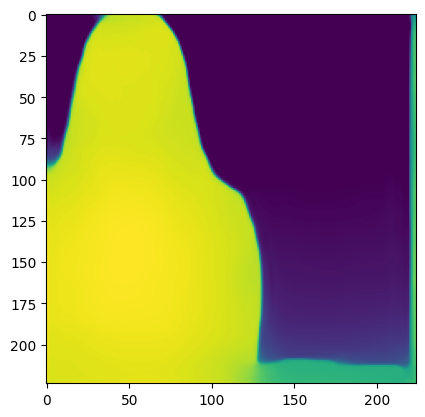

In [181]:
plt.imshow(next(img_iter).cpu().numpy())

In [184]:
y = prediction.reshape(batch_size, 32, 224, 224)

In [185]:
y.shape

torch.Size([2, 32, 224, 224])

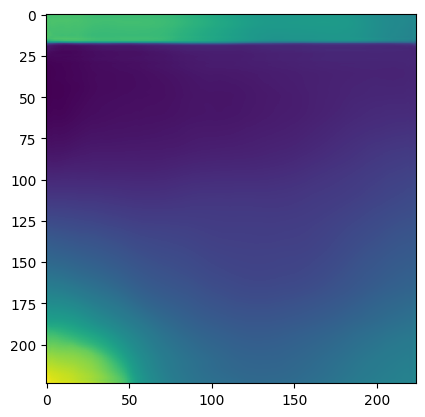

In [187]:
plt.imshow(y[1][0].cpu().numpy())

In [144]:
import torchvision

resize = torchvision.transforms.Resize((224, 224))

In [145]:
resized = resize(prediction)
resized.shape

torch.Size([32, 224, 224])

In [146]:
img_iter = iter(resized)

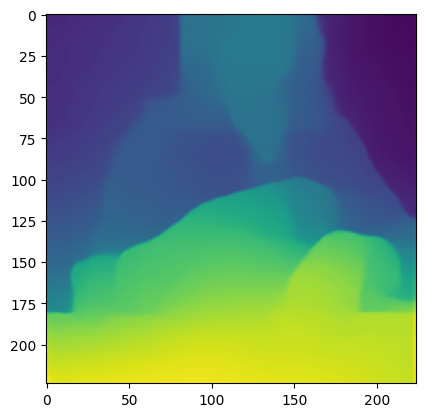

In [147]:
plt.imshow(next(img_iter).cpu().numpy())

## Hybrid

In [35]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type).to(device)

Using cache found in /home/sadat/.cache/torch/hub/intel-isl_MiDaS_master


In [36]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

prediction.shape

torch.Size([32, 1213, 1546])

In [37]:
img_iter = iter(prediction)

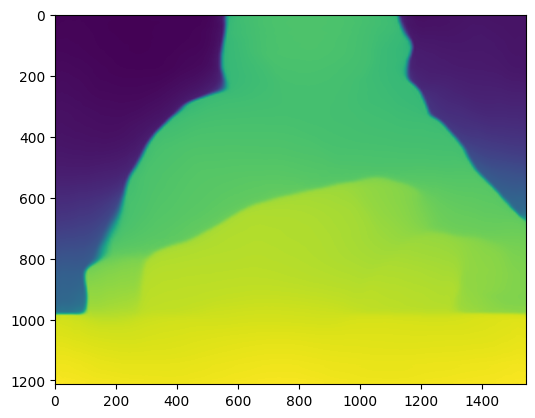

In [38]:
plt.imshow(next(img_iter).cpu().numpy())

## Small

In [44]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type).to(device)

Using cache found in /home/sadat/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/archive/master.zip" to /home/sadat/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /home/sadat/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /home/sadat/.cache/torch/hub/checkpoints/midas_v21_small_256.pt
100%|██████████████████████████████████████| 81.8M/81.8M [00:11<00:00, 7.66MB/s]


In [87]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

prediction.shape

torch.Size([32, 1213, 1546])

In [88]:
img_iter = iter(prediction)

In [121]:
plt.imshow(next(img_iter).cpu().numpy())

StopIteration: 